## O objetivo do modelo é tentar prever se uma determinada pessoa sobreviveu ou não ao acidente do Titanic, baseado em variaveis como Sexo, idade, cabine e etc...

## 1 - Importando bibliotecas e os Datasets

In [1]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_bc35090cb55e457e8fa8a5d7dedb014e = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='x86QfTz27smAKrYS1l5DZJ3g8f-vm72FM_WBAr26vg0S',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_bc35090cb55e457e8fa8a5d7dedb014e.get_object(Bucket='projetoml-donotdelete-pr-zzv4rae25mycdq',Key='test.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

test = pd.read_csv(body)
test.head()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [2]:

body = client_bc35090cb55e457e8fa8a5d7dedb014e.get_object(Bucket='projetoml-donotdelete-pr-zzv4rae25mycdq',Key='train.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

train = pd.read_csv(body)
train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Para o problema em questão, usarei um modelo de Random Forest

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np 

## 2 - Criando o Modelo e Tratando os dados

In [4]:
modelo = RandomForestClassifier(n_estimators = 100,
                                n_jobs = 1, 
                                random_state = 0)

In [5]:
## Transformando a feature "Sex" em binária 
def sex_bin(value):
    if value == 'female':
        return 1 
    else: 
        return 0 
        

In [6]:
train['Sex_bin'] = train['Sex'].map(sex_bin)
test['Sex_bin'] = test['Sex'].map(sex_bin)

In [7]:
## Definindo features usadas no modelo
variaveis = ['Age','Sex_bin']


In [8]:
x = train[variaveis]
y = train['Survived']

In [9]:
## Trantando os NaN's 
# Existem varios modos de lidar com NaN.
## Nesse caso, eu optei por preencher com um valor que não tem sentido para nenhuma das Features.
## No caso,-1 já que ninguem tem idade negativa, e o sexo binário varia entre 0 e 1 

x = x.fillna(-1)

In [10]:
## Split no data set de Treino para fazer validação.
np.random.seed(0)
X_train, X_valid, y_train,y_valid = train_test_split(x,y, test_size = 0.5)

In [11]:
## Treinando modelo
modelo.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [12]:
p = modelo.predict(X_valid)

In [13]:
## Acuracia
np.mean(p == y_valid)

0.7690582959641256

In [14]:
## Gender submission -> Acuracia se assumirmos que todas as mulheres sobreviveram.
p2 = (X_valid['Sex_bin'] == 1).astype(np.int64)
np.mean(p2== y_valid)

0.7825112107623319

In [15]:
## Isso mostra que o modelo ainda não e útil, pois se assumirmos que todas as mulheres sobreviveram, seremos mais precisos do que o modelo.

## Cross validation

In [16]:
## A Cross Validation é uma validação mais robusta/pesada que diminui a eleatoriedade da divisao do conjunto de teste e treino, 
  #e portanto é mais confiável
## Por ser uma validação mais robusta, ela funciona muito bem em datasets menores mas com grandes quantidades de dados pode ser muito custoso.


In [17]:
from sklearn.model_selection import RepeatedKFold

In [18]:
resultados = []

In [19]:
Kfold = RepeatedKFold(n_splits = 2,n_repeats = 10, random_state = 0)

In [20]:

for linhas_treino, linhas_teste in Kfold.split(x):
    print("Treino: ", linhas_treino.shape[0]) 
    print("Teste: ", linhas_teste.shape[0])
     
    X_train, X_valid = x.iloc[linhas_treino], x.iloc[linhas_teste]
    y_train, y_valid = y.iloc[linhas_treino], y.iloc[linhas_teste]
    
        
    modelo = RandomForestClassifier(n_estimators = 100,
                                    n_jobs = -1, 
                                    random_state = 0)
    modelo.fit(X_train, y_train)
    p = modelo.predict(X_valid)
    
    acc = np.mean(y_valid == p )
    resultados.append(acc)
    print("Acc:", acc)
    print()
            
    

Treino:  445
Teste:  446
Acc: 0.7713004484304933

Treino:  446
Teste:  445
Acc: 0.7797752808988764

Treino:  445
Teste:  446
Acc: 0.7331838565022422

Treino:  446
Teste:  445
Acc: 0.7640449438202247

Treino:  445
Teste:  446
Acc: 0.7466367713004485

Treino:  446
Teste:  445
Acc: 0.7617977528089888

Treino:  445
Teste:  446
Acc: 0.757847533632287

Treino:  446
Teste:  445
Acc: 0.7617977528089888

Treino:  445
Teste:  446
Acc: 0.757847533632287

Treino:  446
Teste:  445
Acc: 0.7707865168539326

Treino:  445
Teste:  446
Acc: 0.7466367713004485

Treino:  446
Teste:  445
Acc: 0.7617977528089888

Treino:  445
Teste:  446
Acc: 0.7645739910313901

Treino:  446
Teste:  445
Acc: 0.7685393258426966

Treino:  445
Teste:  446
Acc: 0.7399103139013453

Treino:  446
Teste:  445
Acc: 0.7707865168539326

Treino:  445
Teste:  446
Acc: 0.7399103139013453

Treino:  446
Teste:  445
Acc: 0.7438202247191011

Treino:  445
Teste:  446
Acc: 0.742152466367713

Treino:  446
Teste:  445
Acc: 0.7730337078651686



In [21]:
np.mean(resultados)

0.757808988764045

In [22]:
%matplotlib inline 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


(array([1., 3., 3., 0., 0., 2., 5., 1., 4., 1.]),
 array([0.73318386, 0.737843  , 0.74250214, 0.74716128, 0.75182043,
        0.75647957, 0.76113871, 0.76579785, 0.770457  , 0.77511614,
        0.77977528]),
 <a list of 10 Patch objects>)

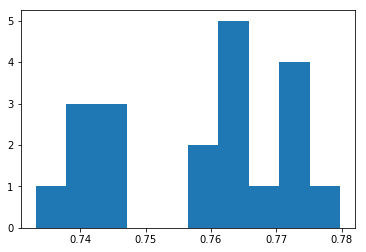

In [23]:
pylab.hist(resultados)

## Adicionando mais variaveis ao modelo

In [24]:
train.head()
## Pclass - > classe
## SibSp -> Viajando com irmao/esposa
## Parch -> Viajando com pais/filhos
## Fare -> Valor da passagem

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_bin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


modelo_anterior = 0.7591522648259181


In [25]:
variaveis = variaveis + ['Pclass','SibSp','Parch','Fare']

In [26]:
x = train[variaveis]
x= x.fillna(-1)
y= train["Survived"]


In [27]:
resultados2 = []

In [28]:
Kfold = RepeatedKFold(n_splits = 2,n_repeats = 10, random_state = 0)

In [29]:
for linhas_treino, linhas_teste in Kfold.split(x):
    print("Treino: ", linhas_treino.shape[0]) 
    print("Teste: ", linhas_teste.shape[0])
     
    X_train, X_valid = x.iloc[linhas_treino], x.iloc[linhas_teste]
    y_train, y_valid = y.iloc[linhas_treino], y.iloc[linhas_teste]
    
        
    modelo = RandomForestClassifier(n_estimators = 100,
                                    n_jobs = -1, 
                                    random_state = 0)
    modelo.fit(X_train, y_train)
    p = modelo.predict(X_valid)
    
    acc = np.mean(y_valid == p )
    resultados2.append(acc)
    print("Acc:", acc)
    print()

Treino:  445
Teste:  446
Acc: 0.7757847533632287

Treino:  446
Teste:  445
Acc: 0.8269662921348314

Treino:  445
Teste:  446
Acc: 0.8116591928251121

Treino:  446
Teste:  445
Acc: 0.8202247191011236

Treino:  445
Teste:  446
Acc: 0.804932735426009

Treino:  446
Teste:  445
Acc: 0.7932584269662921

Treino:  445
Teste:  446
Acc: 0.7982062780269058

Treino:  446
Teste:  445
Acc: 0.7842696629213484

Treino:  445
Teste:  446
Acc: 0.7847533632286996

Treino:  446
Teste:  445
Acc: 0.8157303370786517

Treino:  445
Teste:  446
Acc: 0.7914798206278026

Treino:  446
Teste:  445
Acc: 0.8269662921348314

Treino:  445
Teste:  446
Acc: 0.7937219730941704

Treino:  446
Teste:  445
Acc: 0.7887640449438202

Treino:  445
Teste:  446
Acc: 0.7847533632286996

Treino:  446
Teste:  445
Acc: 0.8224719101123595

Treino:  445
Teste:  446
Acc: 0.7892376681614349

Treino:  446
Teste:  445
Acc: 0.7797752808988764

Treino:  445
Teste:  446
Acc: 0.8116591928251121

Treino:  446
Teste:  445
Acc: 0.8247191011235955



In [30]:
np.mean(resultados2)

0.8014667204111454

(array([2., 3., 2., 3., 1., 1., 0., 3., 1., 4.]),
 array([0.77578475, 0.78090291, 0.78602106, 0.79113921, 0.79625737,
        0.80137552, 0.80649368, 0.81161183, 0.81672998, 0.82184814,
        0.82696629]),
 <a list of 10 Patch objects>)

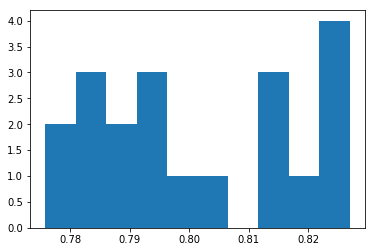

In [31]:
pylab.hist(resultados2)


## ANÁLISE DE ERRO

In [32]:
## O objetivo aqui é identificar aonde o modelo está errando p/ tentar faze-lo acertar

X_valid_check = train.iloc[linhas_teste].copy()
X_valid_check['p'] = p 
X_valid_check.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_bin,p
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0,0


In [33]:
## Selecionando somente os registros que o modelo errou;
erros = X_valid_check[X_valid_check["Survived"] != X_valid_check["p"]]
erros = erros[["PassengerId","Pclass","Name","Sex","Age","SibSp","Parch","Ticket","Fare","Cabin","Embarked","Sex_bin","Survived","p"]]

In [34]:
erros.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_bin,Survived,p
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,1,1,0
14,15,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S,1,0,1
21,22,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S,0,1,0
25,26,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,S,1,1,0
36,37,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C,0,1,0


In [35]:
## Agora, o objetivo é identificar padrões de erro. 
##Uma das formas para fazer isso é olhar algum grupo especifico
## Nesse caso, vou avaliar os grupos Homem e mulher


mulheres = erros[erros['Sex_bin'] == 1]
homens = erros[erros['Sex_bin'] == 0] 



In [36]:
mulheres.sort_values('Survived')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_bin,Survived,p
357,358,2,"Funk, Miss. Annie Clemmer",female,38.0,0,0,237671,13.0000,NaN,S,1,0,1
854,855,2,"Carter, Mrs. Ernest Courtenay (Lilian Hughes)",female,44.0,1,0,244252,26.0000,NaN,S,1,0,1
534,535,3,"Cacic, Miss. Marija",female,30.0,0,0,315084,8.6625,NaN,S,1,0,1
312,313,2,"Lahtinen, Mrs. William (Anna Sylfven)",female,26.0,1,1,250651,26.0000,NaN,S,1,0,1
297,298,1,"Allison, Miss. Helen Loraine",female,2.0,1,2,113781,151.5500,C22 C26,S,1,0,1
617,618,3,"Lobb, Mrs. William Arthur (Cordelia K Stanlick)",female,26.0,1,0,A/5. 3336,16.1000,NaN,S,1,0,1
501,502,3,"Canavan, Miss. Mary",female,21.0,0,0,364846,7.7500,NaN,Q,1,0,1
205,206,3,"Strom, Miss. Telma Matilda",female,2.0,0,1,347054,10.4625,G6,S,1,0,1
729,730,3,"Ilmakangas, Miss. Pieta Sofia",female,25.0,1,0,STON/O2. 3101271,7.9250,NaN,S,1,0,1
772,773,2,"Mack, Mrs. (Mary)",female,57.0,0,0,S.O./P.P. 3,10.5000,E77,S,1,0,1


In [37]:
## É possivel que variáveis que ainda não foram utilizadas no modelo, como por ex: Embarked que se refere ao porto, Numero do Ticket e cabine 
## tenham influencia nos resultados. 

## Nessa etapa é importante analisar profundamente as diferenças entre os dados, e levantar hipóteses: 

    ## Por que algumas passagens tem nomenclatura diferente das outras? Será que isso tem alguma influencia?
    ## Sera que cada um dos portos tem alguma caracteristica que aumente ou diminua as chances de sobrevivencia? 
    ## Algumas mulheres são referenciadas como Mrs e outras como Miss. Será que isso é relevante? 
    ## Alguns registros não constam a cabine do passageiro. Será que isso diz algo? 
    ## Alguns registros mostram mais de um valor para a cabine. Isso pode nos dizer algo? 


## NOVAS VARIÁVEIS

In [38]:
train['Embarked_S'] = (train["Embarked"] == 'S').astype(int)
train['Embarked_C'] = (train["Embarked"] == 'C').astype(int) 
##train['Embarked_Q'] = (train['Embarked'] == 'Q').astype(int) ## Essa coluna nao é necessária pois se não embarcou nem no porto S nem no porto C, automaticamente embarcou no Q

train['Null_cabin'] = train['Cabin'].isnull().astype(int)
train['Nome_contem_miss'] = train['Name'].str.contains("Miss").astype(int) ## str.astype é equivalente ao like '%%' do SQl
train['Nome_contem_col'] = train['Name'].str.contains("Col").astype(int) ## str.astype é equivalente ao like '%%' do SQl
train['Nome_contem_major'] = train['Name'].str.contains("Major").astype(int) ## str.astype é equivalente ao like '%%' do SQl
train['Nome_contem_mr'] = train['Name'].str.contains("Mr").astype(int) ## str.astype é equivalente ao like '%%' do SQl

In [39]:
train['Nome_contem_mrs'] = train['Name'].str.contains("Mrs").astype(int) ## str.astype é equivalente ao like '%%' do SQl

In [40]:
variaveis

['Age', 'Sex_bin', 'Pclass', 'SibSp', 'Parch', 'Fare']

In [41]:
variaveis = variaveis + ['Embarked_S','Embarked_C','Null_cabin','Nome_contem_miss','Nome_contem_col','Nome_contem_major','Nome_contem_mr']

In [42]:
variaveis = variaveis + ['Nome_contem_mrs']

In [43]:
x = train[variaveis]
x= x.fillna(-1)
y = train['Survived']


In [44]:
from sklearn.linear_model import LogisticRegression

In [45]:
resultados3 = []

Kfold = RepeatedKFold(n_splits = 2,n_repeats = 10, random_state = 0) ## mudando a random_state, a acc muda. 35 ate agora foi o melhor

for linhas_treino, linhas_teste in Kfold.split(x):
    print("Treino: ", linhas_treino.shape[0]) 
    print("Teste: ", linhas_teste.shape[0])
     
    X_train, X_valid = x.iloc[linhas_treino], x.iloc[linhas_teste]
    y_train, y_valid = y.iloc[linhas_treino], y.iloc[linhas_teste]
    
        
    ##modelo = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 0) -- vou tentar usar um modelo diferente.
    modelo = LogisticRegression()
    
    modelo.fit(X_train, y_train)
    p = modelo.predict(X_valid)
    
    acc = np.mean(y_valid == p )
    resultados3.append(acc)
    print("Acc:", acc)
    print()

Treino:  445
Teste:  446
Acc: 0.8026905829596412

Treino:  446
Teste:  445
Acc: 0.8179775280898877

Treino:  445
Teste:  446
Acc: 0.7982062780269058

Treino:  446
Teste:  445
Acc: 0.802247191011236

Treino:  445
Teste:  446
Acc: 0.8071748878923767

Treino:  446
Teste:  445
Acc: 0.7932584269662921

Treino:  445
Teste:  446
Acc: 0.7959641255605381

Treino:  446
Teste:  445
Acc: 0.8

Treino:  445
Teste:  446
Acc: 0.7892376681614349

Treino:  446
Teste:  445
Acc: 0.7955056179775281

Treino:  445
Teste:  446
Acc: 0.7847533632286996

Treino:  446
Teste:  445
Acc: 0.8044943820224719

Treino:  445
Teste:  446
Acc: 0.7959641255605381

Treino:  446
Teste:  445
Acc: 0.7910112359550562

Treino:  445
Teste:  446
Acc: 0.773542600896861

Treino:  446
Teste:  445
Acc: 0.8292134831460675

Treino:  445
Teste:  446
Acc: 0.820627802690583

Treino:  446
Teste:  445
Acc: 0.7820224719101123

Treino:  445
Teste:  446
Acc: 0.7937219730941704

Treino:  446
Teste:  445
Acc: 0.7910112359550562



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

((array([1., 1., 2., 5., 4., 3., 1., 1., 1., 1.]),
  array([0.7735426 , 0.77910969, 0.78467678, 0.79024387, 0.79581095,
         0.80137804, 0.80694513, 0.81251222, 0.81807931, 0.82364639,
         0.82921348]),
  <a list of 10 Patch objects>),
 (array([2., 3., 2., 3., 1., 1., 0., 3., 1., 4.]),
  array([0.77578475, 0.78090291, 0.78602106, 0.79113921, 0.79625737,
         0.80137552, 0.80649368, 0.81161183, 0.81672998, 0.82184814,
         0.82696629]),
  <a list of 10 Patch objects>))

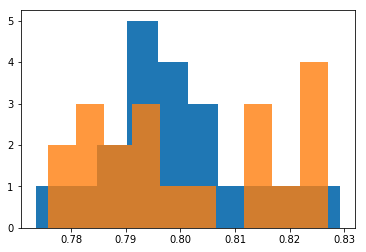

In [46]:
pylab.hist(resultados3), pylab.hist(resultados2, alpha = 0.8)

In [47]:
np.mean(resultados3)

0.7984312490552727

In [48]:
np.mean(resultados2)

0.8014667204111454

In [49]:
## Função p/ contar a qtd de palavras de uma string

def nw(string):
    x = 0
    for i in string: 
        if (i.isspace()):
            x +=1
        else: 
            x = x 
    return x

In [56]:
train['Qtd_cabins'] = train['Cabin'].map(nw)

In [55]:
train['Cabin'] = str(train['Cabin'])

In [58]:
train['Cabin']

0      0              NaN\n1              C85\n2     ...
1      0              NaN\n1              C85\n2     ...
2      0              NaN\n1              C85\n2     ...
3      0              NaN\n1              C85\n2     ...
4      0              NaN\n1              C85\n2     ...
5      0              NaN\n1              C85\n2     ...
6      0              NaN\n1              C85\n2     ...
7      0              NaN\n1              C85\n2     ...
8      0              NaN\n1              C85\n2     ...
9      0              NaN\n1              C85\n2     ...
10     0              NaN\n1              C85\n2     ...
11     0              NaN\n1              C85\n2     ...
12     0              NaN\n1              C85\n2     ...
13     0              NaN\n1              C85\n2     ...
14     0              NaN\n1              C85\n2     ...
15     0              NaN\n1              C85\n2     ...
16     0              NaN\n1              C85\n2     ...
17     0              NaN\n1   

In [ ]:
##teste

In [ ]:
test['Sex_bin'] = test['Sex'].map(sex_bin)
x = x.fillna(-1)
test[variaveis]
test = test.fillna(-1)

In [ ]:
modelo = RandomForestClassifier(n_estimators = 100,
                                    n_jobs = -1, 
                                    random_state = 0)
modelo.fit(x,y)
p = modelo.predict(test[variaveis])

## Criar submission no Kaggle p/ obter acuracia do teste

In [ ]:
sub = pd.Series(p, index=test['PassengerId'], name = 'Survived')
sub.shape

In [ ]:
sub.to_csv("modelo.csv", header = True)

In [ ]:
!head -n10 modelo.csv